In [1]:
%%capture
# Only run this cell if you need to install the libraries
# If running in google colab, this is needed.

#!pip install cadcad matplotlib pandas numpy

In [2]:
# Import dependancies

# Data processing and plotting libraries
import pandas as pd
import numpy as np
from random import normalvariate
import matplotlib.pyplot as plt

# cadCAD specific libraries
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionContext, Executor

In [1]:
diff_smoothing_factor = 5760
price_smoothing_factor = 12960

# Historical modeling

In [4]:
from historical_model import HistoricalModel
from smoothing_function import ExponentialMovingAverage

hm = HistoricalModel(
    ExponentialMovingAverage(price_smoothing_factor), 
    ExponentialMovingAverage(diff_smoothing_factor)
)
hm.initialize_state()
MONTE_CARLO_RUNS = 1
SIMULATION_TIMESTEPS = len(hm.btc_diff_data)

sim_config = config_sim(
    {
        'N': MONTE_CARLO_RUNS,
        'T': range(SIMULATION_TIMESTEPS)
    }
)

Running just the normal configuration (no volatility, historical data since 2016)

In [5]:
from cadCAD import configs
del configs[:]

experiment = Experiment()

experiment.append_configs(
    sim_configs=sim_config,
    initial_state=hm.get_initial_state(),
    partial_state_update_blocks=hm.partial_state_update_blocks,
)

exec_context = ExecutionContext()
run = Executor(exec_context=exec_context, configs=experiment.configs)

(system_events, tensor_field, sessions) = run.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 65240, 0, 1, 7)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (65240, 0, 1, 7)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 14.63s


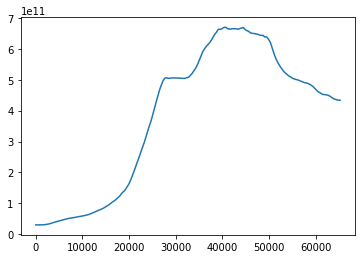

In [6]:
import matplotlib.pyplot as plt
df = pd.DataFrame(system_events)
plt.plot(df['timestep'], df['kdiff_smoothed'])
plt.show()

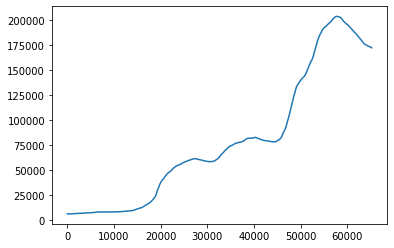

In [7]:
plt.plot(df['timestep'], df['blockreward_smoothed'])
plt.show()

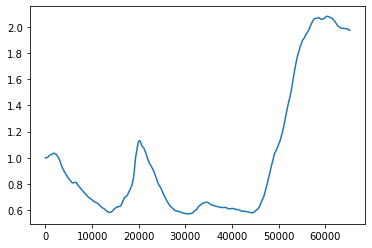

In [8]:
plt.plot(df['timestep'], df['led_price'])
plt.show()

# Basic volatility modeling

In [9]:
# Import dependancies

# Data processing and plotting libraries
import pandas as pd
import numpy as np
from random import normalvariate
import matplotlib.pyplot as plt

# cadCAD specific libraries
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionContext, Executor

In [10]:
# Set volatility/trend params here
params = {
    # Yearly standard deviation values for volatility
    'diff_vol_std_dev': [0.5],
    'price_vol_std_dev': [0.5],

    # Trend values in yearly APY
    # This is a constant percentage gain/loss applied over time
    # diff_trend 0.5271 will more or less counteract koomey period
    'diff_trend': [0.5271],
    'price_trend': [0]
}

In [11]:
from volatility_model import VolatilityModel
from smoothing_function import ExponentialMovingAverage

vm = VolatilityModel(
    ExponentialMovingAverage(price_smoothing_factor), 
    ExponentialMovingAverage(diff_smoothing_factor)
)
vm.initialize_state()

MONTE_CARLO_RUNS = 1
SIMULATION_TIMESTEPS = 50000

sim_config = config_sim(
    {
        'N': MONTE_CARLO_RUNS,
        'T': range(SIMULATION_TIMESTEPS),
        'M': params
    }
)

In [12]:
from cadCAD import configs
del configs[:]

experiment = Experiment()

experiment.append_configs(
    sim_configs=sim_config,
    initial_state=vm.get_initial_state(),
    partial_state_update_blocks=vm.partial_state_update_blocks,
)

exec_context = ExecutionContext()
run = Executor(exec_context=exec_context, configs=experiment.configs)

(system_events, tensor_field, sessions) = run.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 50000, 4, 1, 7)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (50000, 4, 1, 7)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 15.30s


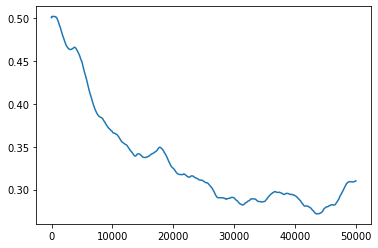

In [13]:
import matplotlib.pyplot as plt
df = pd.DataFrame(system_events)
for sim in range(MONTE_CARLO_RUNS):
    rows = df.loc[df['run'] == sim+1]
    plt.plot(rows['timestep'], rows['kdiff_smoothed'])
plt.show()

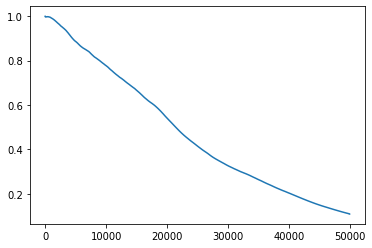

In [14]:
for sim in range(MONTE_CARLO_RUNS):
    rows = df.loc[df['run'] == sim+1]
    plt.plot(rows['timestep'], rows['blockreward_smoothed'])
plt.show()

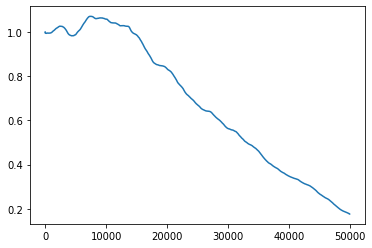

In [15]:
for sim in range(MONTE_CARLO_RUNS):
    rows = df.loc[df['run'] == sim+1]
    plt.plot(rows['timestep'], rows['led_price'])
plt.show()

# Price spike modeling

In this model, we set the price to some large value, and control how quickly the difficulty converges to equalize

In [1]:
# Import dependancies

# Data processing and plotting libraries
import pandas as pd
import numpy as np
from random import normalvariate
import matplotlib.pyplot as plt

# cadCAD specific libraries
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionContext, Executor

In [2]:
diff_smoothing_factor = 5760
price_smoothing_factor = 12960
# Set diff convergence param here
params = {
    # How quickly the difficulty converges on price
    # 1 is instant, lower values converge logarithmically
    'diff_convergence': [0.7]
}

# Change this to control severity of price spike
btc_price = 1000000

In [3]:
from price_spike_model import PriceSpikeModel
from smoothing_function import ExponentialMovingAverage

psm = PriceSpikeModel(
    ExponentialMovingAverage(price_smoothing_factor), 
    ExponentialMovingAverage(diff_smoothing_factor),
    btc_price
)
psm.initialize_state()

# import old_price_spike as psm

MONTE_CARLO_RUNS = 1
SIMULATION_TIMESTEPS = 50000

sim_config = config_sim(
    {
        'N': MONTE_CARLO_RUNS,
        'T': range(SIMULATION_TIMESTEPS),
        'M': params
    }
)

In [4]:
from cadCAD import configs
del configs[:]

experiment = Experiment()

experiment.append_configs(
    sim_configs=sim_config,
    initial_state=psm.get_initial_state(params),
    partial_state_update_blocks=psm.partial_state_update_blocks,
)

exec_context = ExecutionContext()
run = Executor(exec_context=exec_context, configs=experiment.configs)

(system_events, tensor_field, sessions) = run.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 50000, 1, 1, 7)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (50000, 1, 1, 7)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 11.22s


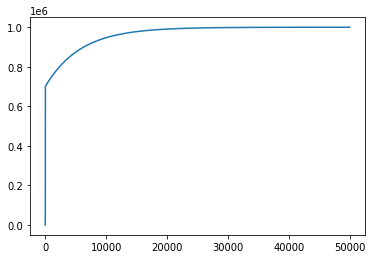

In [5]:
import matplotlib.pyplot as plt
df = pd.DataFrame(system_events)
for sim in range(MONTE_CARLO_RUNS):
    rows = df.loc[df['run'] == sim+1]
    plt.plot(rows['timestep'], rows['kdiff_smoothed'])
plt.show()

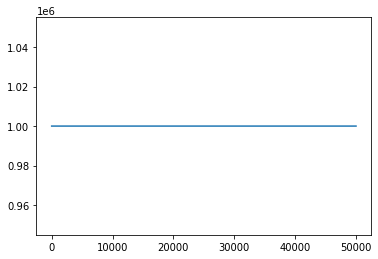

In [6]:
for sim in range(MONTE_CARLO_RUNS):
    rows = df.loc[df['run'] == sim+1]
    plt.plot(rows['timestep'], rows['blockreward_smoothed'])
plt.show()

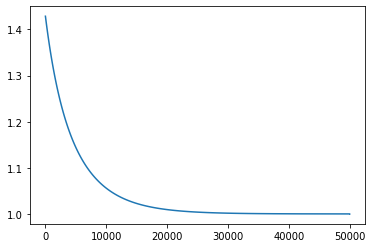

In [7]:
for sim in range(MONTE_CARLO_RUNS):
    rows = df.loc[df['run'] == sim+1].iloc[1:]
    plt.plot(rows['timestep'], rows['led_price'])
plt.show()